# The Annotated GAT

The idea of this notebook is to make it easier even for non-researchers to understand the Graph Attention Network (and GNNs in general)!

In this notebook you'll get answers to these questions:

✅ What is GAT exactly? <br/>
✅ How to train it? <br/>
✅ How to use it (Cora classification example)? <br/>

After you complete this one you'll have a much better understanding of graph neural networks in general!

*Note: Cora is a transductive setting, I'll be adding an inductive example soon as well (PPI - protein protein interaction, probably).*

Nice, let's start!

---

## What the heck are Graph Attention Networks?

Graph Attention Network, or GAT for short, is a Graph Neural Network (GNN) published by `Veličković et al.` in a paper called [Graph Attention Networks](https://arxiv.org/abs/1710.10903) back in 2017.

It turns out that combining the idea of **attention** with the already existing **graphs convolutional networks** (GCN) was a good move 🤓 - GAT is the **2nd most cited** paper in the GNN literature (as of the time of writing this).

So because `GCN + attention = GAT` in order to understand GAT you basically need to understand GCNs.

The whole idea came from CNNs (*stack push GCN (a nervous chuckle)*). Convolutional Neural Networks were working so nicely, solving various computer vision tasks and creating a huge hype in the world of deep learning, so some folks decided to transfer the idea onto graphs.

The basic problem is that while the image lies on a regular grid (which you can also treat as a graph (*sighs*)), and thus has a precise notion of **order** (e.g. my **top-left** neighboor (*popularly known as pixels in the CV world*)), graphs don't enjoy that nice property and both the number of neighbors as well as the order of neighbors may vary. 

So how can you define a kernel for a graph? The kernel size can't be `3x3` because sometimes a node will have 2 neighbors and sometimes 233240 (*breaks the keyboard*).

2 main ideas popped up:
* **spectral methods** (they all somehow leverage the graph Laplacian eigenbasis (I'll completely ignore them here))
* **spatial methods** 

Although spatial methods can vaguely be motivated by the spectral ones it's much more healthy to think of them directly from the spatial perspective. Ok, here it goes. (*stack pop GCN*)

---

**High level explanation of spatial (message passing) methods:** 

So you have the feature vectors from your neighbors at your disposal. You do the following:

1. You somehow transform them (maybe a linear projection)
2. You somehow aggregate them (maybe weighing them with attention coefficients, voilà, we get GAT (*you see what I did there*))
3. You update the feature vector (somehow) of the current node by combining it's (transformed) feature vector with the aggregated neighborhood representation.

And that's pretty much it, you can fit many different GNNs into this framework.

Here is how GAT schematic looks like (those differently colored edges represent different attention heads):

<img src="data/readme_pics/GAT_schematic.PNG" alt="transformer architecture" align="center" style="width: 500px;"/> <br/>

**Fun fact:** *transformers* can be thought of as a special case of *GAT* - when the input graph is **fully-connected**. Check out [this blog](https://thegradient.pub/transformers-are-graph-neural-networks/) for more details.

---

That was everything you need to know for now! <br/>

If you need further help understanding all of the details I created this [in-depth overview of the GAT paper:](https://www.youtube.com/watch?v=uFLeKkXWq2c)

<a href="https://www.youtube.com/watch?v=uFLeKkXWq2c" target="_blank"><img src="https://img.youtube.com/vi/uFLeKkXWq2c/0.jpg" 
alt="An in-depth overview of the Graph Attention Networks" width="480" align="left" height="360" border="10" /></a>

**Important note: the code in this notebook is a strict subset of the code that's at your disposal in this repository. I'll focus on a single GAT implementation here (the conceptually hardest one to understand, but at the same time the most efficient one). Note that I actually have 3 GAT implementations in the repo.**

**If you want me to cover something additionally, open up a "feature" request issue.** ❤️

With that out of the way let's dig in! Let's start with imports related to data loading and visualization.

In [1]:
# I always like to structure my imports into Python's native libs,
# stuff I installed via conda/pip and local file imports (but we don't have those here)

import pickle

# Visualization related imports
import matplotlib.pyplot as plt
import networkx as nx
import igraph as ig

# Main computation libraries
import scipy.sparse as sp
import numpy as np

# Deep learning related imports
import torch

In [2]:
"""
    Contains constants needed for data loading and visualization.

"""

import os
import enum


# Supported datasets - currently only Cora (I'll be adding PPI)
class DatasetType(enum.Enum):
    CORA = 0

    
# Networkx is not precisely made with drawing as it's main feature but I experimented with it a bit
class GraphVisualizationTool(enum.Enum):
    NETWORKX = 0,
    IGRAPH = 1


# We'll be dumping and reading the data from this directory
DATA_DIR_PATH = os.path.join(os.getcwd(), 'data')
CORA_PATH = os.path.join(DATA_DIR_PATH, 'cora')  # this is checked-in no need to make a directory

#
# Cora specific constants
#

# Thomas Kipf et al. first used this split in GCN paper and later Petar Veličković et al. in GAT paper
CORA_TRAIN_RANGE = [0, 140]  # we're using the first 140 nodes as the training nodes
CORA_VAL_RANGE = [140, 140+500]
CORA_TEST_RANGE = [1708, 1708+1000]
CORA_NUM_INPUT_FEATURES = 1433
CORA_NUM_CLASSES = 7

# Used whenever we need to visualzie points from different classes (t-SNE, CORA visualization)
cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

With that out of the way we've got the level 1 unlocked (Data 📜). 😍 Let's go!

# Part 1: Understanding your data (become One with the data 📜❤️)

I'll be using Cora citation network as the running example and I'll probably add an inductive example soon (like protein-protein interactions (PPI) dataset).

Having said that, you may wonder, what's the difference between `transductive` and `inductive` setting? If you're not familiar with GNNs this may appear as a weird concept. But it's quite simple actually.

**Transductive** - you have a single graph (like Cora) you split some **nodes** (and not graphs) into train/val/test training sets. While you're training you'll be using only the labels from your training nodes. BUT. During the forward prop, by the nature of how spatial GNNs work, you'll be aggregating the feature vectors from your neighbors and **some of them may belong to val or even test sets!** The main point is - you **ARE NOT** using their label information but you **ARE** using the structural information and their features.

**Inductive** - you're probably much more familiar with this one if you come from the computer vision or NLP background. You have a set of training graphs, a separate set of val graphs and of course a separate set of test graphs.

Having explained that let's jump into the code and let's load and visualize Cora.

In [3]:
# First let's define these simple functios for loading/saving Pickle files - we need them for Cora

# All Cora data is stored as pickle
def pickle_read(path):
    with open(path, 'rb') as file:
        data = pickle.load(file)

    return data

def pickle_save(path, data):
    with open(path, 'wb') as file:
        pickle.dump(data, file, protocol=pickle.HIGHEST_PROTOCOL)

Now let's see how we can load Cora!

In [4]:
# We'll pass the training config dictionary a bit later
def load_graph_data(training_config, device):
    dataset_name = training_config['dataset_name'].lower()
    should_visualize = training_config['should_visualize']

    if dataset_name == DatasetType.CORA.name.lower():

        # shape = (N, FIN), where N is the number of nodes and FIN is the number of input features
        node_features_csr = pickle_read(os.path.join(CORA_PATH, 'node_features.csr'))
        # shape = (N, 1)
        node_labels_npy = pickle_read(os.path.join(CORA_PATH, 'node_labels.npy'))
        # shape = (N, number of neighboring nodes) <- this is a dictionary not a matrix!
        adjacency_list_dict = pickle_read(os.path.join(CORA_PATH, 'adjacency_list.dict'))

        # Normalize the features (helps with training)
        node_features_csr = normalize_features_sparse(node_features_csr)
        num_of_nodes = len(node_labels_npy)

        # shape = (2, E), where E is the number of edges, and 2 for source and target nodes. Basically edge index
        # contains tuples of the format S->T, e.g. 0->3 means that node with id 0 points to a node with id 3.
        topology = build_edge_index(adjacency_list_dict, num_of_nodes, add_self_edges=True)

        # Note: topology is just a fancy way of naming the graph structure data 
        # (aside from edge index it could be in the form of an adjacency matrix)

        if should_visualize:  # network analysis and graph drawing
            plot_in_out_degree_distributions(topology, num_of_nodes, dataset_name)  # we'll define these in a second
            visualize_graph(topology, node_labels_npy, dataset_name)

        # Convert to dense PyTorch tensors

        # Needs to be long int type because later functions like PyTorch's index_select expect it
        topology = torch.tensor(topology, dtype=torch.long, device=device)
        node_labels = torch.tensor(node_labels_npy, dtype=torch.long, device=device)  # Cross entropy expects a long int
        node_features = torch.tensor(node_features_csr.todense(), device=device)

        # Indices that help us extract nodes that belong to the train/val and test splits
        train_indices = torch.arange(CORA_TRAIN_RANGE[0], CORA_TRAIN_RANGE[1], dtype=torch.long, device=device)
        val_indices = torch.arange(CORA_VAL_RANGE[0], CORA_VAL_RANGE[1], dtype=torch.long, device=device)
        test_indices = torch.arange(CORA_TEST_RANGE[0], CORA_TEST_RANGE[1], dtype=torch.long, device=device)

        return node_features, node_labels, topology, train_indices, val_indices, test_indices
    else:
        raise Exception(f'{dataset_name} not yet supported.')

Nice, there are 2 more functions that I've used that we're yet to define. First let's see how we do **feature normalization** on Cora:

In [5]:
def normalize_features_sparse(node_features_sparse):
    assert sp.issparse(node_features_sparse), f'Expected a sparse matrix, got {node_features_sparse}.'

    # Instead of dividing (like in normalize_features_dense()) we do multiplication with inverse sum of features.
    # Modern hardware (GPUs, TPUs, ASICs) is optimized for fast matrix multiplications! ^^ (* >> /)
    # shape = (N, FIN) -> (N, 1), where N number of nodes and FIN number of input features
    node_features_sum = np.array(node_features_sparse.sum(-1))  # sum features for every node feature vector

    # Make an inverse (remember * by 1/x is better (faster) then / by x)
    # shape = (N, 1) -> (N)
    node_features_inv_sum = np.power(node_features_sum, -1).squeeze()

    # Again certain sums will be 0 so 1/0 will give us inf so we replace those by 1 which is a neutral element for mul
    node_features_inv_sum[np.isinf(node_features_inv_sum)] = 1.

    # Create a diagonal matrix whose values on the diagonal come from node_features_inv_sum
    diagonal_inv_features_sum_matrix = sp.diags(node_features_inv_sum)

    # We return the normalized features.
    return diagonal_inv_features_sum_matrix.dot(node_features_sparse)

It's basically making Cora's binary node feature vectors sum up to 1. Example if we had `[1, 0, 1, 0, 1]` (Cora's feature vectors are longer as we'll soon see but let's take this one for the time being), it will get transformed into `[0.33, 0, 0.33, 0, 0.33]`. Simple as that. It's always harder to understand the actual implementation, but conceptually, it's a piece of cake.

That out of the way let's build up that **edge index**:

In [6]:
def build_edge_index(adjacency_list_dict, num_of_nodes, add_self_edges=True):
    source_nodes_ids, target_nodes_ids = [], []
    seen_edges = set()

    for src_node, neighboring_nodes in adjacency_list_dict.items():
        for trg_node in neighboring_nodes:
            # if this edge hasn't been seen so far we add it to the edge index (coalescing - removing duplicates)
            if (src_node, trg_node) not in seen_edges:  # it'd be easy to explicitly remove self-edges (Cora has none..)
                source_nodes_ids.append(src_node)
                target_nodes_ids.append(trg_node)

                seen_edges.add((src_node, trg_node))

    if add_self_edges:
        source_nodes_ids.extend(np.arange(num_of_nodes))
        target_nodes_ids.extend(np.arange(num_of_nodes))

    # shape = (2, E), where E is the number of edges in the graph
    edge_index = np.row_stack((source_nodes_ids, target_nodes_ids))

    return edge_index

This one should be fairly simple - we just accumulate the edges in this format: <br/>
[[0, 1], [2, 2], ...] where [s, t] tuple basically defines an edge where node `s` (source) points to node `t` (target).

Other popular format (used in my other 2 implementations) is the **adjacency matrix** - but those take up way more memory (O(N^2) to be precise, compare that to O(E) for the edge index structure).

Nice, finally let's try and load it. We should also analyze the shapes - that's always a good idea.

In [7]:
# Let's just define dummy visualization functions for now - just to stop Python interpreter from complaining!
# We'll define them in a moment, properly, I swear.

def plot_in_out_degree_distributions():
    pass

def visualize_graph():
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # checking whether you have a GPU

config = {
    'dataset_name': DatasetType.CORA.name,
    'should_visualize': False
}

node_features, node_labels, edge_index, train_indices, val_indices, test_indices = load_graph_data(config, device)

print(node_features.shape, node_features.dtype)
print(node_labels.shape, node_labels.dtype)
print(edge_index.shape, edge_index.dtype)
print(train_indices.shape, train_indices.dtype)
print(val_indices.shape, val_indices.dtype)
print(test_indices.shape, test_indices.dtype)

torch.Size([2708, 1433]) torch.float32
torch.Size([2708]) torch.int64
torch.Size([2, 13264]) torch.int64
torch.Size([140]) torch.int64
torch.Size([500]) torch.int64
torch.Size([1000]) torch.int64


Nice! Analyzing the shapes we see the following:
1. Cora has 2708 nodes
2. Each node has 1433 features (check out [data_loading.py](https://github.com/gordicaleksa/pytorch-GAT/blob/main/utils/data_loading.py) for much more detail)
3. We have 13264 edges! (including the self edges)
4. We have 140 training nodes
5. We have 500 val nodes
6. We have 1000 test nodes

Additionally almost all of the data is of int 64 type. Why? Well it's a constraint that PyTorch is imposing upon us.
The loss function `nn.CrossEntropyLoss` and `index_select` functions require torch.long (i.e. 64 bit integer) - that's it.

* `node_labels` is int64 because of `nn.CrossEntropyLoss`
* other vars are int64 because of `index_select`

On the "side note", it's always a **good idea to test your code as you're progressing.** 

Data loading is completely orthogonal to the rest of this notebook so we can test it, standalone, and make sure the shapes and datatypes make sense. I use this strategy while developing projects like this one (and in general).

I start with data, I add the loading functionality, I add some visualizations and only then do I usually start developing the deep learning model itself.

Visualizations are a huge bonus, so let's develop them.

# Visualizing your data 🔮👓

Let's start by understanding the degree distribution of nodes in Cora - i.e. how many input/output edges do nodes have, a certain measure of connectedness of the graph.

Run the following cell:

In [8]:
def plot_in_out_degree_distributions(edge_index, num_of_nodes, dataset_name):
    """
        Note: It would be easy to do various kinds of powerful network analysis using igraph/networkx, etc.
        I chose to explicitly calculate only the node degree statistics here, but you can go much further if needed and
        calculate the graph diameter, number of triangles and many other concepts from the network analysis field.

    """
    if isinstance(edge_index, torch.Tensor):
        edge_index = edge_index.cpu().numpy()
        
    assert isinstance(edge_index, np.ndarray), f'Expected NumPy array got {type(edge_index)}.'

    # Store each node's input and output degree (they're the same for undirected graphs such as Cora)
    in_degrees = np.zeros(num_of_nodes, dtype=np.int)
    out_degrees = np.zeros(num_of_nodes, dtype=np.int)

    # Edge index shape = (2, E), the first row contains the source nodes, the second one target/sink nodes
    # Note on terminology: source nodes point to target/sink nodes
    num_of_edges = edge_index.shape[1]
    for cnt in range(num_of_edges):
        source_node_id = edge_index[0, cnt]
        target_node_id = edge_index[1, cnt]

        out_degrees[source_node_id] += 1  # source node points towards some other node -> increment it's out degree
        in_degrees[target_node_id] += 1  # similarly here

    hist = np.zeros(np.max(out_degrees) + 1)
    for out_degree in out_degrees:
        hist[out_degree] += 1

    fig = plt.figure(figsize=(12,8), dpi=100)  # otherwise plots are really small in Jupyter Notebook
    fig.subplots_adjust(hspace=0.6)

    plt.subplot(311)
    plt.plot(in_degrees, color='red')
    plt.xlabel('node id'); plt.ylabel('in-degree count'); plt.title('Input degree for different node ids')

    plt.subplot(312)
    plt.plot(out_degrees, color='green')
    plt.xlabel('node id'); plt.ylabel('out-degree count'); plt.title('Out degree for different node ids')

    plt.subplot(313)
    plt.plot(hist, color='blue')
    plt.xlabel('node degree'); plt.ylabel('# nodes for a given out-degree'); plt.title(f'Node out-degree distribution for {dataset_name} dataset')
    plt.xticks(np.arange(0, len(hist), 5.0))

    plt.grid(True)
    plt.show()

Brilliant, let's now visualize Cora's degree distributions!

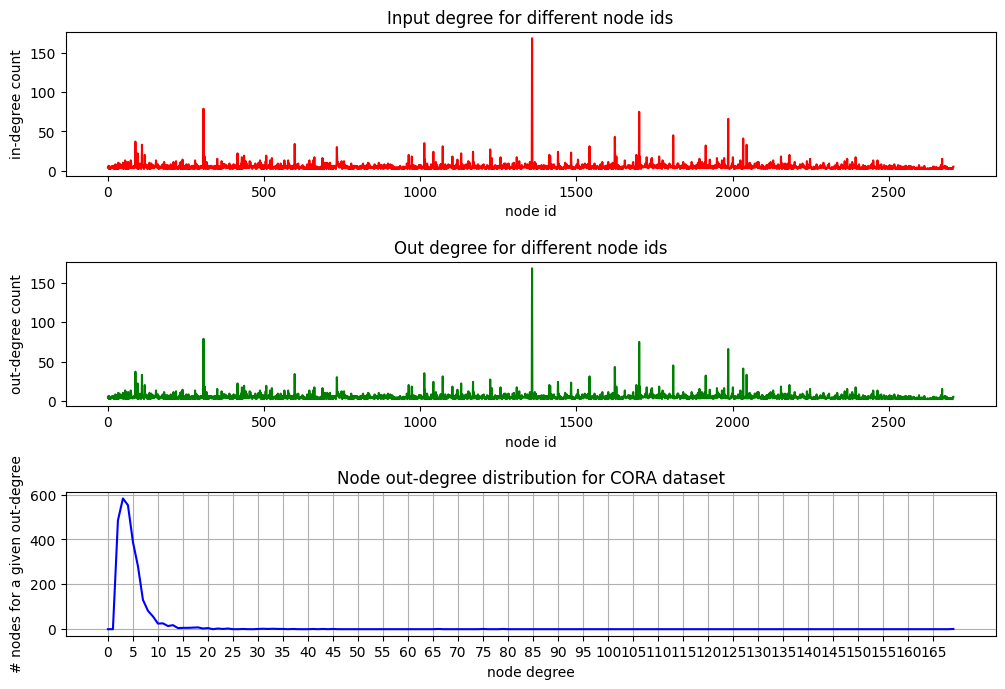

In [9]:
num_of_nodes = len(node_labels)
plot_in_out_degree_distributions(edge_index, num_of_nodes, config['dataset_name'])

You can immediately notice a couple of things:
* The top 2 plots are the same, because we treat Cora as an undirected graph (even though it should naturally be modeled as a directed graph)
* Certain nodes have a huge number of edges (the peak in the middle) but most nodes have far less edges
* The third plot nicely visualizes this in the form of a histogram - most nodes have only `2-5` edges (hence the peak on the leftmost side)

Ok, we're starting to get some valuable insight into Cora, let's continue further and literally visualize/see Cora.

The following cell will plot Cora, run it. (*whispers: run it*)

In [10]:
"""
Check out this blog for available graph visualization tools:
    https://towardsdatascience.com/large-graph-visualization-tools-and-approaches-2b8758a1cd59

Basically depending on how big your graph is there may be better drawing tools than igraph.

Note: I unfortunatelly had to flatten this function since igraph is having some problems with Jupyter Notebook,
we'll only call it here so it's fine!

"""

dataset_name = config['dataset_name']
visualization_tool=GraphVisualizationTool.IGRAPH

if isinstance(edge_index, torch.Tensor):
    edge_index_np = edge_index.cpu().numpy()

if isinstance(node_labels, torch.Tensor):
    node_labels_np = node_labels.cpu().numpy()

num_of_nodes = len(node_labels_np)
edge_index_tuples = list(zip(edge_index_np[0, :], edge_index_np[1, :]))  # igraph requires this format

# Construct the igraph graph
ig_graph = ig.Graph()
ig_graph.add_vertices(num_of_nodes)
ig_graph.add_edges(edge_index_tuples)

# Prepare the visualization settings dictionary
visual_style = {}

# Defines the size of the plot and margins
# go berserk here try (3000, 3000) it looks amazing in Jupyter!!! (you'll have to adjust the vertex_size though!)
visual_style["bbox"] = (700, 700)
visual_style["margin"] = 5

# I've chosen the edge thickness such that it's proportional to the number of shortest paths (geodesics)
# that go through a certain edge in our graph (edge_betweenness function, a simple ad hoc heuristic)

# line1: I use log otherwise some edges will be too thick and others not visible at all
# edge_betweeness returns < 1 for certain edges that's why I use clip as log would be negative for those edges
# line2: Normalize so that the thickest edge is 1 otherwise edges appear too thick on the chart
# line3: The idea here is to make the strongest edge stay stronger than others, 6 just worked, don't dwell on it

edge_weights_raw = np.clip(np.log(np.asarray(ig_graph.edge_betweenness())+1e-16), a_min=0, a_max=None)
edge_weights_raw_normalized = edge_weights_raw / np.max(edge_weights_raw)
edge_weights = [w**6 for w in edge_weights_raw_normalized]
visual_style["edge_width"] = edge_weights

# A simple heuristic for vertex size. Size ~ (degree / 4) (it gave nice results I tried log and sqrt as well)
visual_style["vertex_size"] = [deg / 4 for deg in ig_graph.degree()]

# This is the only part that's Cora specific as Cora has 7 labels
if dataset_name.lower() == DatasetType.CORA.name.lower():
    visual_style["vertex_color"] = [cora_label_to_color_map[label] for label in node_labels_np]
else:
    print('Feel free to add custom color scheme for your specific dataset. Using igraph default coloring.')

# Set the layout - the way the graph is presented on a 2D chart. Graph drawing is a subfield for itself!
# I used "Kamada Kawai" a force-directed method, this family of methods are based on physical system simulation.
# (layout_drl also gave nice results for Cora)
visual_style["layout"] = ig_graph.layout_kamada_kawai()

print('Plotting results ... (it may take couple of seconds).')
ig.plot(ig_graph, **visual_style)

# This website has got some awesome visualizations check it out:
# http://networkrepository.com/graphvis.php?d=./data/gsm50/labeled/cora.edges

Plotting results ... (it may take couple of seconds).


I don't know about you, but I think this one is beautiful!

Try running it with `visual_style["bbox"]` set to `(3000, 3000)` and use `/ 2` in `vertex_size` and you'll get a huuuge and awesome plot (`C` handles the plotting behind igraph so it's pretty fast on my machine at least - with some minor lagging when you scroll over it).

Ok we're done with visualizations and understanding our data. This is a huge milestone, so tap yourself on the back. 🏆🎂🎵

We have the level 2 unlocked (the GAT model 🦄). 😍

And now, let's understand the model! 💪

# Part 2: Understanding GAT's inner workings 💻🦄

First let's create a high level class where we'll build up `GAT` from `GatLayer` objects. 

It basically just stacks the layers into a nn.Sequential object and additionally since nn.Sequential expects a single input (and it has a single output) I just pack the data (features, edge index) into a tuple - *pure syntactic sugar*. 

In [11]:
import torch.nn as nn
from torch.optim import Adam


class GAT(torch.nn.Module):
    """
    The most interesting and hardest implementation is implementation #3.
    Imp1 and imp2 differ in subtle details but are basically the same thing.

    So I'll focus on imp #3 in this notebook.

    """

    def __init__(self, num_of_layers, num_heads_per_layer, num_features_per_layer, add_skip_connection=True, bias=True,
                 dropout=0.6, log_attention_weights=False):
        super().__init__()
        assert num_of_layers == len(num_heads_per_layer) == len(num_features_per_layer) - 1, f'Enter valid arch params.'

        num_heads_per_layer = [1] + num_heads_per_layer  # trick - so that I can nicely create GAT layers below

        gat_layers = []  # collect GAT layers
        for i in range(num_of_layers):
            layer = GATLayer(
                num_in_features=num_features_per_layer[i] * num_heads_per_layer[i],  # consequence of concatenation
                num_out_features=num_features_per_layer[i+1],
                num_of_heads=num_heads_per_layer[i+1],
                concat=True if i < num_of_layers - 1 else False,  # last GAT layer does mean avg, the others do concat
                activation=nn.ELU() if i < num_of_layers - 1 else None,  # last layer just outputs raw scores
                dropout_prob=dropout,
                add_skip_connection=add_skip_connection,
                bias=bias,
                log_attention_weights=log_attention_weights
            )
            gat_layers.append(layer)

        self.gat_net = nn.Sequential(
            *gat_layers,
        )

    # data is just a (in_nodes_features, edge_index) tuple, I had to do it like this because of the nn.Sequential:
    # https://discuss.pytorch.org/t/forward-takes-2-positional-arguments-but-3-were-given-for-nn-sqeuential-with-linear-layers/65698
    def forward(self, data):
        return self.gat_net(data)

Now for the fun part let's define the layer. 

I really don't think that I can explain it any better, using words, than you taking your time to digest the code and the comments.

Also make sure to check out [my video on GAT](https://www.youtube.com/watch?v=uFLeKkXWq2c) before you start losing time trying to figure it out "from scratch". It's always good to have some theoretical background at your hand.

In [12]:
class GATLayer(torch.nn.Module):
    """
    Implementation #3 was inspired by PyTorch Geometric: https://github.com/rusty1s/pytorch_geometric

    But, it's hopefully much more readable! (and of similar performance)

    """
    
    # We'll use these constants in many functions so just extracting them here as member fields
    src_nodes_dim = 0  # position of source nodes in edge index
    trg_nodes_dim = 1  # position of target nodes in edge index

    # These may change in the inductive setting - leaving it like this for now (not future proof)
    nodes_dim = 0      # node dimension (axis is maybe a more familiar term nodes_dim is the position of "N" in tensor)
    head_dim = 1       # attention head dim

    def __init__(self, num_in_features, num_out_features, num_of_heads, concat=True, activation=nn.ELU(),
                 dropout_prob=0.6, add_skip_connection=True, bias=True, log_attention_weights=False):

        super().__init__()

        self.num_of_heads = num_of_heads
        self.num_out_features = num_out_features
        self.concat = concat  # whether we should concatenate or average the attention heads
        self.add_skip_connection = add_skip_connection

        #
        # Trainable weights: linear projection matrix (denoted as "W" in the paper), attention target/source
        # (denoted as "a" in the paper) and bias (not mentioned in the paper but present in the official GAT repo)
        #

        # You can treat this one matrix as num_of_heads independent W matrices
        self.linear_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)

        # After we concatenate target node (node i) and source node (node j) we apply the "additive" scoring function
        # which gives us un-normalized score "e". Here we split the "a" vector - but the semantics remain the same.
        # Basically instead of doing [x, y] (concatenation, x/y are node feature vectors) and dot product with "a"
        # we instead do a dot product between x and "a_left" and y and "a_right" and we sum them up
        self.scoring_fn_target = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))
        self.scoring_fn_source = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))

        # Bias is definitely not crucial to GAT - feel free to experiment (I pinged the main author, Petar, on this one)
        if bias and concat:
            self.bias = nn.Parameter(torch.Tensor(num_of_heads * num_out_features))
        elif bias and not concat:
            self.bias = nn.Parameter(torch.Tensor(num_out_features))
        else:
            self.register_parameter('bias', None)

        if add_skip_connection:
            self.skip_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)
        else:
            self.register_parameter('skip_proj', None)

        #
        # End of trainable weights
        #

        self.leakyReLU = nn.LeakyReLU(0.2)  # using 0.2 as in the paper, no need to expose every setting
        self.activation = activation
        # Probably not the nicest design but I use the same module in 3 locations, before/after features projection
        # and for attention coefficients. Functionality-wise it's the same as using independent modules.
        self.dropout = nn.Dropout(p=dropout_prob)

        self.log_attention_weights = log_attention_weights  # whether we should log the attention weights
        self.attention_weights = None  # for later visualization purposes, I cache the weights here

        self.init_params()
        
    def forward(self, data):
        #
        # Step 1: Linear Projection + regularization
        #

        in_nodes_features, edge_index = data  # unpack data
        num_of_nodes = in_nodes_features.shape[self.nodes_dim]
        assert edge_index.shape[0] == 2, f'Expected edge index with shape=(2,E) got {edge_index.shape}'

        # shape = (N, FIN) where N - number of nodes in the graph, FIN - number of input features per node
        # We apply the dropout to all of the input node features (as mentioned in the paper)
        # Note: for Cora features are already super sparse so it's questionable how much this actually helps
        in_nodes_features = self.dropout(in_nodes_features)

        # shape = (N, FIN) * (FIN, NH*FOUT) -> (N, NH, FOUT) where NH - number of heads, FOUT - num of output features
        # We project the input node features into NH independent output features (one for each attention head)
        nodes_features_proj = self.linear_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)

        nodes_features_proj = self.dropout(nodes_features_proj)  # in the official GAT imp they did dropout here as well

        #
        # Step 2: Edge attention calculation
        #

        # Apply the scoring function (* represents element-wise (a.k.a. Hadamard) product)
        # shape = (N, NH, FOUT) * (1, NH, FOUT) -> (N, NH, 1) -> (N, NH) because sum squeezes the last dimension
        # Optimization note: torch.sum() is as performant as .sum() in my experiments
        scores_source = (nodes_features_proj * self.scoring_fn_source).sum(dim=-1)
        scores_target = (nodes_features_proj * self.scoring_fn_target).sum(dim=-1)

        # We simply copy (lift) the scores for source/target nodes based on the edge index. Instead of preparing all
        # the possible combinations of scores we just prepare those that will actually be used and those are defined
        # by the edge index.
        # scores shape = (E, NH), nodes_features_proj_lifted shape = (E, NH, FOUT), E - number of edges in the graph
        scores_source_lifted, scores_target_lifted, nodes_features_proj_lifted = self.lift(scores_source, scores_target, nodes_features_proj, edge_index)
        scores_per_edge = self.leakyReLU(scores_source_lifted + scores_target_lifted)

        # shape = (E, NH, 1)
        attentions_per_edge = self.neighborhood_aware_softmax(scores_per_edge, edge_index[self.trg_nodes_dim], num_of_nodes)
        # Add stochasticity to neighborhood aggregation
        attentions_per_edge = self.dropout(attentions_per_edge)

        #
        # Step 3: Neighborhood aggregation
        #

        # Element-wise (aka Hadamard) product. Operator * does the same thing as torch.mul
        # shape = (E, NH, FOUT) * (E, NH, 1) -> (E, NH, FOUT), 1 gets broadcast into FOUT
        nodes_features_proj_lifted_weighted = nodes_features_proj_lifted * attentions_per_edge

        # This part sums up weighted and projected neighborhood feature vectors for every target node
        # shape = (N, NH, FOUT)
        out_nodes_features = self.aggregate_neighbors(nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes)

        #
        # Step 4: Residual/skip connections, concat and bias
        #

        out_nodes_features = self.skip_concat_bias(attentions_per_edge, in_nodes_features, out_nodes_features)
        return (out_nodes_features, edge_index)

    #
    # Helper functions (without comments there is very little code so don't be scared!)
    #

    def neighborhood_aware_softmax(self, scores_per_edge, trg_index, num_of_nodes):
        """
        As the fn name suggest it does softmax over the neighborhoods. Example: say we have 5 nodes in a graph.
        Two of them 1, 2 are connected to node 3. If we want to calculate the representation for node 3 we should take
        into account feature vectors of 1, 2 and 3 itself. Since we have scores for edges 1-3, 2-3 and 3-3
        in scores_per_edge variable, this function will calculate attention scores like this: 1-3/(1-3+2-3+3-3)
        (where 1-3 is overloaded notation it represents the edge 1-3 and it's (exp) score) and similarly for 2-3 and 3-3
         i.e. for this neighborhood we don't care about other edge scores that include nodes 4 and 5.

        Note:
        Subtracting the max value from logits doesn't change the end result but it improves the numerical stability
        and it's a fairly common "trick" used in pretty much every deep learning framework.
        Check out this link for more details:

        https://stats.stackexchange.com/questions/338285/how-does-the-subtraction-of-the-logit-maximum-improve-learning

        """
        # Calculate the numerator. Make logits <= 0 so that e^logit <= 1 (this will improve the numerical stability)
        scores_per_edge = scores_per_edge - scores_per_edge.max()
        exp_scores_per_edge = scores_per_edge.exp()  # softmax

        # Calculate the denominator. shape = (E, NH)
        neigborhood_aware_denominator = self.sum_edge_scores_neighborhood_aware(exp_scores_per_edge, trg_index, num_of_nodes)

        # 1e-16 is theoretically not needed but is only there for numerical stability (avoid div by 0) - due to the
        # possibility of the computer rounding a very small number all the way to 0.
        attentions_per_edge = exp_scores_per_edge / (neigborhood_aware_denominator + 1e-16)

        # shape = (E, NH) -> (E, NH, 1) so that we can do element-wise multiplication with projected node features
        return attentions_per_edge.unsqueeze(-1)

    def sum_edge_scores_neighborhood_aware(self, exp_scores_per_edge, trg_index, num_of_nodes):
        # The shape must be the same as in exp_scores_per_edge (required by scatter_add_) i.e. from E -> (E, NH)
        trg_index_broadcasted = self.explicit_broadcast(trg_index, exp_scores_per_edge)

        # shape = (N, NH), where N is the number of nodes and NH the number of attention heads
        size = list(exp_scores_per_edge.shape)  # convert to list otherwise assignment is not possible
        size[self.nodes_dim] = num_of_nodes
        neighborhood_sums = torch.zeros(size, dtype=exp_scores_per_edge.dtype, device=exp_scores_per_edge.device)

        # position i will contain a sum of exp scores of all the nodes that point to the node i (as dictated by the
        # target index)
        neighborhood_sums.scatter_add_(self.nodes_dim, trg_index_broadcasted, exp_scores_per_edge)

        # Expand again so that we can use it as a softmax denominator. e.g. node i's sum will be copied to
        # all the locations where the source nodes pointed to i (as dictated by the target index)
        # shape = (N, NH) -> (E, NH)
        return neighborhood_sums.index_select(self.nodes_dim, trg_index)

    def aggregate_neighbors(self, nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes):
        size = list(nodes_features_proj_lifted_weighted.shape)  # convert to list otherwise assignment is not possible
        size[self.nodes_dim] = num_of_nodes  # shape = (N, NH, FOUT)
        out_nodes_features = torch.zeros(size, dtype=in_nodes_features.dtype, device=in_nodes_features.device)

        # shape = (E) -> (E, NH, FOUT)
        trg_index_broadcasted = self.explicit_broadcast(edge_index[self.trg_nodes_dim], nodes_features_proj_lifted_weighted)
        # aggregation step - we accumulate projected, weighted node features for all the attention heads
        # shape = (E, NH, FOUT) -> (N, NH, FOUT)
        out_nodes_features.scatter_add_(self.nodes_dim, trg_index_broadcasted, nodes_features_proj_lifted_weighted)

        return out_nodes_features

    def lift(self, scores_source, scores_target, nodes_features_matrix_proj, edge_index):
        """
        Lifts i.e. duplicates certain vectors depending on the edge index.
        One of the tensor dims goes from N -> E (that's where the "lift" comes from).

        """
        src_nodes_index = edge_index[self.src_nodes_dim]
        trg_nodes_index = edge_index[self.trg_nodes_dim]

        # Using index_select is faster than "normal" indexing (scores_source[src_nodes_index]) in PyTorch!
        scores_source = scores_source.index_select(self.nodes_dim, src_nodes_index)
        scores_target = scores_target.index_select(self.nodes_dim, trg_nodes_index)
        nodes_features_matrix_proj_lifted = nodes_features_matrix_proj.index_select(self.nodes_dim, src_nodes_index)

        return scores_source, scores_target, nodes_features_matrix_proj_lifted

    def explicit_broadcast(self, this, other):
        # Append singleton dimensions until this.dim() == other.dim()
        for _ in range(this.dim(), other.dim()):
            this = this.unsqueeze(-1)

        # Explicitly expand so that shapes are the same
        return this.expand_as(other)

    def init_params(self):
        """
        The reason we're using Glorot (aka Xavier uniform) initialization is because it's a default TF initialization:
            https://stackoverflow.com/questions/37350131/what-is-the-default-variable-initializer-in-tensorflow

        The original repo was developed in TensorFlow (TF) and they used the default initialization.
        Feel free to experiment - there may be better initializations depending on your problem.

        """
        nn.init.xavier_uniform_(self.linear_proj.weight)
        nn.init.xavier_uniform_(self.scoring_fn_target)
        nn.init.xavier_uniform_(self.scoring_fn_source)

        if self.bias is not None:
            torch.nn.init.zeros_(self.bias)

    def skip_concat_bias(self, attention_coefficients, in_nodes_features, out_nodes_features):
        if self.log_attention_weights:  # potentially log for later visualization in playground.py
            self.attention_weights = attention_coefficients

        if self.add_skip_connection:  # add skip or residual connection
            if out_nodes_features.shape[-1] == in_nodes_features.shape[-1]:  # if FIN == FOUT
                # unsqueeze does this: (N, FIN) -> (N, 1, FIN), out features are (N, NH, FOUT) so 1 gets broadcast to NH
                # thus we're basically copying input vectors NH times and adding to processed vectors
                out_nodes_features += in_nodes_features.unsqueeze(1)
            else:
                # FIN != FOUT so we need to project input feature vectors into dimension that can be added to output
                # feature vectors. skip_proj adds lots of additional capacity which may cause overfitting.
                out_nodes_features += self.skip_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)

        if self.concat:
            # shape = (N, NH, FOUT) -> (N, NH*FOUT)
            out_nodes_features = out_nodes_features.view(-1, self.num_of_heads * self.num_out_features)
        else:
            # shape = (N, NH, FOUT) -> (N, FOUT)
            out_nodes_features = out_nodes_features.mean(dim=self.head_dim)

        if self.bias is not None:
            out_nodes_features += self.bias

        return out_nodes_features if self.activation is None else self.activation(out_nodes_features)

The main idea that leads to huge savings is that we calculate the scores only for the nodes that will actually be used and not for every imaginable combination (that would be valid only in a fully-connected graph).

Once we compute the `"left"` scores and the `"right"` scores, we "lift" them up using the edge index. That way
if the edge `1->2` is not present in the graph we won't have those score pairs in our data structure.

After adding lifted "left" and "right" (or maybe a better naming would be source and target) scores we do smart `neighborhood-aware softmax` - so that the semantics of GAT is respected. After doing the `scatter add` (which you should take your time to understand and go through the docs) we can combine the projected feature vectors, and voila, we got ourselves a fully-blown GAT layer.

---

Take your time and **be patient**! Especially if you're knew to GNNs. 

I didn't learn all of this in 1 day, it takes time for the knowledge to sink in. You'll get there as well! ❤️ (if you're not already there 😜)

Having said that, we've got the level 3 unlocked (model training 💪). 😍

We have the data 📜 ready, we have the GAT model 🦄 ready, let's start training this beast! 💪

# Part 3: Training GAT 💪 (Classification on Cora!)

Phew, well the hardest part is behind us. Let's know create a simple training loop where the goal is to learn to classify Cora nodes.

But first let's define some relevant constants. 

In [13]:
from torch.utils.tensorboard import SummaryWriter


# 3 different model training/eval phases used in train.py
class LoopPhase(enum.Enum):
    TRAIN = 0,
    VAL = 1,
    TEST = 2

    
writer = SummaryWriter()  # (tensorboard) writer will output to ./runs/ directory by default


# Global vars used for early stopping. After some number of epochs (as defined by the patience_period var) without any
# improvement on the validation dataset (measured via accuracy metric), we'll break out from the training loop.
BEST_VAL_ACC = 0
BEST_VAL_LOSS = 0
PATIENCE_CNT = 0

BINARIES_PATH = os.path.join(os.getcwd(), 'models', 'binaries')
CHECKPOINTS_PATH = os.path.join(os.getcwd(), 'models', 'checkpoints')

# Make sure these exist as the rest of the code assumes it
os.makedirs(BINARIES_PATH, exist_ok=True)
os.makedirs(CHECKPOINTS_PATH, exist_ok=True)

Also, let's define a couple of functions that will be useful while training the model.

The training state contains a lot of useful `metadata` which we can later use. You can imagine that saving the test accuracy of your model is important, especially when you're training your models on a cloud - it makes the organization so much better.

In [14]:
import git
import re  # regex


def get_training_state(training_config, model):
    training_state = {
        "commit_hash": git.Repo(search_parent_directories=True).head.object.hexsha,

        # Training details
        "dataset_name": training_config['dataset_name'],
        "num_of_epochs": training_config['num_of_epochs'],
        "test_acc": training_config['test_acc'],

        # Model structure
        "num_of_layers": training_config['num_of_layers'],
        "num_heads_per_layer": training_config['num_heads_per_layer'],
        "num_features_per_layer": training_config['num_features_per_layer'],
        "add_skip_connection": training_config['add_skip_connection'],
        "bias": training_config['bias'],
        "dropout": training_config['dropout'],

        # Model state
        "state_dict": model.state_dict()
    }

    return training_state


def print_model_metadata(training_state):
    header = f'\n{"*"*5} Model training metadata: {"*"*5}'
    print(header)

    for key, value in training_state.items():
        if key != 'state_dict':  # don't print state_dict it's a bunch of numbers...
            print(f'{key}: {value}')
    print(f'{"*" * len(header)}\n')


# This one makes sure we don't overwrite the valuable model binaries (feel free to ignore - not crucial to GAT method)
def get_available_binary_name():
    prefix = 'gat'

    def valid_binary_name(binary_name):
        # First time you see raw f-string? Don't worry the only trick is to double the brackets.
        pattern = re.compile(rf'{prefix}_[0-9]{{6}}\.pth')
        return re.fullmatch(pattern, binary_name) is not None

    # Just list the existing binaries so that we don't overwrite them but write to a new one
    valid_binary_names = list(filter(valid_binary_name, os.listdir(BINARIES_PATH)))
    if len(valid_binary_names) > 0:
        last_binary_name = sorted(valid_binary_names)[-1]
        new_suffix = int(last_binary_name.split('.')[0][-6:]) + 1  # increment by 1
        return f'{prefix}_{str(new_suffix).zfill(6)}.pth'
    else:
        return f'{prefix}_000000.pth'

Nice, now `argparse` is just a nice way to **organize** your program settings:

In [15]:
import argparse


def get_training_args():
    parser = argparse.ArgumentParser()

    # Training related
    parser.add_argument("--num_of_epochs", type=int, help="number of training epochs", default=10000)
    parser.add_argument("--patience_period", type=int, help="number of epochs with no improvement on val before terminating", default=1000)
    parser.add_argument("--lr", type=float, help="model learning rate", default=5e-3)
    parser.add_argument("--weight_decay", type=float, help="L2 regularization on model weights", default=5e-4)
    parser.add_argument("--should_test", type=bool, help='should test the model on the test dataset?', default=True)

    # Dataset related
    parser.add_argument("--dataset_name", choices=[el.name for el in DatasetType], help='dataset to use for training', default=DatasetType.CORA.name)
    parser.add_argument("--should_visualize", type=bool, help='should visualize the dataset?', default=False)

    # Logging/debugging/checkpoint related (helps a lot with experimentation)
    parser.add_argument("--enable_tensorboard", type=bool, help="enable tensorboard logging", default=False)
    parser.add_argument("--console_log_freq", type=int, help="log to output console (epoch) freq (None for no logging)", default=100)
    parser.add_argument("--checkpoint_freq", type=int, help="checkpoint model saving (epoch) freq (None for no logging)", default=1000)
    args = parser.parse_args("")

    # Model architecture related - this is the architecture as defined in the official paper (for Cora classification)
    gat_config = {
        "num_of_layers": 2,  # GNNs, contrary to CNNs, are often shallow (it ultimately depends on the graph properties)
        "num_heads_per_layer": [8, 1],
        "num_features_per_layer": [CORA_NUM_INPUT_FEATURES, 8, CORA_NUM_CLASSES],
        "add_skip_connection": False,  # hurts perf on Cora
        "bias": True,  # result is not so sensitive to bias
        "dropout": 0.6,  # result is sensitive to dropout
    }

    # Wrapping training configuration into a dictionary
    training_config = dict()
    for arg in vars(args):
        training_config[arg] = getattr(args, arg)

    # Add additional config information
    training_config.update(gat_config)

    return training_config

Now for the juice part. 🍪🎅

Here, we organize, high-level, everything we need for training GAT. Just combining the components we already learned.

In [16]:
import time


def train_gat(config):
    global BEST_VAL_ACC, BEST_VAL_LOSS

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # checking whether you have a GPU, I hope so!

    # Step 1: load the graph data
    node_features, node_labels, edge_index, train_indices, val_indices, test_indices = load_graph_data(config, device)

    # Step 2: prepare the model
    gat = GAT(
        num_of_layers=config['num_of_layers'],
        num_heads_per_layer=config['num_heads_per_layer'],
        num_features_per_layer=config['num_features_per_layer'],
        add_skip_connection=config['add_skip_connection'],
        bias=config['bias'],
        dropout=config['dropout'],
        log_attention_weights=False  # no need to store attentions, used only in playground.py while visualizing
    ).to(device)

    # Step 3: Prepare other training related utilities (loss & optimizer and decorator function)
    loss_fn = nn.CrossEntropyLoss(reduction='mean')
    optimizer = Adam(gat.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

    # THIS IS THE CORE OF THE TRAINING (we'll define it in a minute)
    # The decorator function makes things cleaner since there is a lot of redundancy between the train and val loops
    main_loop = get_main_loop(
        config,
        gat,
        loss_fn,
        optimizer,
        node_features,
        node_labels,
        edge_index,
        train_indices,
        val_indices,
        test_indices,
        config['patience_period'],
        time.time())

    BEST_VAL_ACC, BEST_VAL_LOSS, PATIENCE_CNT = [0, 0, 0]  # reset vars used for early stopping

    # Step 4: Start the training procedure
    for epoch in range(config['num_of_epochs']):
        # Training loop
        main_loop(phase=LoopPhase.TRAIN, epoch=epoch)

        # Validation loop
        with torch.no_grad():
            try:
                main_loop(phase=LoopPhase.VAL, epoch=epoch)
            except Exception as e:  # "patience has run out" exception :O
                print(str(e))
                break  # break out from the training loop

    # Step 5: Potentially test your model
    # Don't overfit to the test dataset - only when you've fine-tuned your model on the validation dataset should you
    # report your final loss and accuracy on the test dataset. Friends don't let friends overfit to the test data. <3
    if config['should_test']:
        test_acc = main_loop(phase=LoopPhase.TEST)
        config['test_acc'] = test_acc
        print(f'Test accuracy = {test_acc}')
    else:
        config['test_acc'] = -1

    # Save the latest GAT in the binaries directory
    torch.save(get_training_state(config, gat), os.path.join(BINARIES_PATH, get_available_binary_name()))

🎉🎉🎉 

Now for the core part of the training - the main loop, as I've dubbed it. 

I've organized it like this so that I don't have to copy/paste bunch of the same code for train/val/test loops.

**Friends don't let friends copy/paste (unless it's from the Stack Overflow)**

In [17]:
# Simple decorator function so that I don't have to pass arguments that don't change from epoch to epoch
def get_main_loop(config, gat, cross_entropy_loss, optimizer, node_features, node_labels, edge_index, train_indices, val_indices, test_indices, patience_period, time_start):

    node_dim = 0  # this will likely change as soon as I add an inductive example (Cora is transductive)

    train_labels = node_labels.index_select(node_dim, train_indices)
    val_labels = node_labels.index_select(node_dim, val_indices)
    test_labels = node_labels.index_select(node_dim, test_indices)

    # node_features shape = (N, FIN), edge_index shape = (2, E)
    graph_data = (node_features, edge_index)  # I pack data into tuples because GAT uses nn.Sequential which requires it

    def get_node_indices(phase):
        if phase == LoopPhase.TRAIN:
            return train_indices
        elif phase == LoopPhase.VAL:
            return val_indices
        else:
            return test_indices

    def get_node_labels(phase):
        if phase == LoopPhase.TRAIN:
            return train_labels
        elif phase == LoopPhase.VAL:
            return val_labels
        else:
            return test_labels

    def main_loop(phase, epoch=0):
        global BEST_VAL_ACC, BEST_VAL_LOSS, PATIENCE_CNT, writer

        # Certain modules behave differently depending on whether we're training the model or not.
        # e.g. nn.Dropout - we only want to drop model weights during the training.
        if phase == LoopPhase.TRAIN:
            gat.train()
        else:
            gat.eval()

        node_indices = get_node_indices(phase)
        gt_node_labels = get_node_labels(phase)  # gt stands for ground truth

        # Do a forwards pass and extract only the relevant node scores (train/val or test ones)
        # Note: [0] just extracts the node_features part of the data (index 1 contains the edge_index)
        # shape = (N, C) where N is the number of nodes in the split (train/val/test) and C is the number of classes
        nodes_unnormalized_scores = gat(graph_data)[0].index_select(node_dim, node_indices)

        # Example: let's take an output for a single node on Cora - it's a vector of size 7 and it contains unnormalized
        # scores like: V = [-1.393,  3.0765, -2.4445,  9.6219,  2.1658, -5.5243, -4.6247]
        # What PyTorch's cross entropy loss does is for every such vector it first applies a softmax, and so we'll
        # have the V transformed into: [1.6421e-05, 1.4338e-03, 5.7378e-06, 0.99797, 5.7673e-04, 2.6376e-07, 6.4848e-07]
        # secondly, whatever the correct class is (say it's 3), it will then take the element at position 3,
        # 0.99797 in this case, and the loss will be -log(0.99797). It does this for every node and applies a mean.
        # You can see that as the probability of the correct class for most nodes approaches 1 we get to 0 loss! <3
        loss = cross_entropy_loss(nodes_unnormalized_scores, gt_node_labels)

        if phase == LoopPhase.TRAIN:
            optimizer.zero_grad()  # clean the trainable weights gradients in the computational graph (.grad fields)
            loss.backward()  # compute the gradients for every trainable weight in the computational graph
            optimizer.step()  # apply the gradients to weights

        # Finds the index of maximum (unnormalized) score for every node and that's the class prediction for that node.
        # Compare those to true (ground truth) labels and find the fraction of correct predictions -> accuracy metric.
        class_predictions = torch.argmax(nodes_unnormalized_scores, dim=-1)
        accuracy = torch.sum(torch.eq(class_predictions, gt_node_labels).long()).item() / len(gt_node_labels)

        #
        # Logging
        #

        if phase == LoopPhase.TRAIN:
            # Log metrics
            if config['enable_tensorboard']:
                writer.add_scalar('training_loss', loss.item(), epoch)
                writer.add_scalar('training_acc', accuracy, epoch)

            # Save model checkpoint
            if config['checkpoint_freq'] is not None and (epoch + 1) % config['checkpoint_freq'] == 0:
                ckpt_model_name = f"gat_ckpt_epoch_{epoch + 1}.pth"
                config['test_acc'] = -1
                torch.save(get_training_state(config, gat), os.path.join(CHECKPOINTS_PATH, ckpt_model_name))

        elif phase == LoopPhase.VAL:
            # Log metrics
            if config['enable_tensorboard']:
                writer.add_scalar('val_loss', loss.item(), epoch)
                writer.add_scalar('val_acc', accuracy, epoch)

            # Log to console
            if config['console_log_freq'] is not None and epoch % config['console_log_freq'] == 0:
                print(f'GAT training: time elapsed= {(time.time() - time_start):.2f} [s] | epoch={epoch + 1} | val acc={accuracy}')

            # The "patience" logic - should we break out from the training loop? If either validation acc keeps going up
            # or the val loss keeps going down we won't stop
            if accuracy > BEST_VAL_ACC or loss.item() < BEST_VAL_LOSS:
                BEST_VAL_ACC = max(accuracy, BEST_VAL_ACC)  # keep track of the best validation accuracy so far
                BEST_VAL_LOSS = min(loss.item(), BEST_VAL_LOSS)
                PATIENCE_CNT = 0  # reset the counter every time we encounter new best accuracy
            else:
                PATIENCE_CNT += 1  # otherwise keep counting

            if PATIENCE_CNT >= patience_period:
                raise Exception('Stopping the training, the universe has no more patience for this training.')

        else:
            return accuracy  # in the case of test phase we just report back the test accuracy

    return main_loop  # return the decorated function

That was all we needed! Let's train it! 💪💪💪

In [18]:
# Train the graph attention network (GAT)
train_gat(get_training_args())

GAT training: time elapsed= 0.92 [s] | epoch=1 | val acc=0.128
GAT training: time elapsed= 1.60 [s] | epoch=101 | val acc=0.792
GAT training: time elapsed= 2.18 [s] | epoch=201 | val acc=0.788
GAT training: time elapsed= 2.76 [s] | epoch=301 | val acc=0.81
GAT training: time elapsed= 3.35 [s] | epoch=401 | val acc=0.794
GAT training: time elapsed= 3.94 [s] | epoch=501 | val acc=0.808
GAT training: time elapsed= 4.51 [s] | epoch=601 | val acc=0.804
GAT training: time elapsed= 5.10 [s] | epoch=701 | val acc=0.822
GAT training: time elapsed= 5.69 [s] | epoch=801 | val acc=0.81
GAT training: time elapsed= 6.26 [s] | epoch=901 | val acc=0.796
GAT training: time elapsed= 6.96 [s] | epoch=1001 | val acc=0.808
GAT training: time elapsed= 7.55 [s] | epoch=1101 | val acc=0.802
GAT training: time elapsed= 8.17 [s] | epoch=1201 | val acc=0.804
GAT training: time elapsed= 8.76 [s] | epoch=1301 | val acc=0.79
GAT training: time elapsed= 9.34 [s] | epoch=1401 | val acc=0.804
GAT training: time elapse

Nice!!! 🎉🎉🎉 Level 4 unlocked (GAT visualizations 🔮). 😍

We just achieved `82.5 %` on Cora's test nodes! The same numbers as reported in the original GAT paper!

So we now have everything in place:
1. The data loading and visualizations
2. GAT model defined
3. Training loop setup and the trained model binaries

Now let's play the GAT model under a microscope 🔬🔬🔬 and understand the weights we got - we can do that in many ways.

# Part 4: Visualizing GAT 🔮

Let's define some functions we'll need:

In [19]:
def draw_entropy_histogram(entropy_array, title, color='blue', uniform_distribution=False, num_bins=30):
    max_value = np.max(entropy_array)
    bar_width = (max_value / num_bins) * (1.0 if uniform_distribution else 0.75)
    histogram_values, histogram_bins = np.histogram(entropy_array, bins=num_bins, range=(0.0, max_value))

    plt.bar(histogram_bins[:num_bins], histogram_values[:num_bins], width=bar_width, color=color)
    plt.xlabel(f'entropy bins')
    plt.ylabel(f'# of node neighborhoods')
    plt.title(title)

This code snippet will get called multiple times so let's just extract it inside a function (the main reason is actually that igraph is having problems with Jupyter so I'm working around it 😂)

In [20]:
def prepare_vars(model_name, dataset_name, visualization_type):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # checking whether you have a GPU, I hope so!

    config = {
        'dataset_name': dataset_name,
        'should_visualize': False  # don't visualize the dataset
    }

    # Step 1: Prepare the data
    node_features, node_labels, edge_index, _, _, _ = load_graph_data(config, device)

    # Step 2: Prepare the model
    model_path = os.path.join(BINARIES_PATH, model_name)
    model_state = torch.load(model_path)

    gat = GAT(
        num_of_layers=model_state['num_of_layers'],
        num_heads_per_layer=model_state['num_heads_per_layer'],
        num_features_per_layer=model_state['num_features_per_layer'],
        add_skip_connection=model_state['add_skip_connection'],
        bias=model_state['bias'],
        dropout=model_state['dropout'],
        log_attention_weights=True
    ).to(device)

    print_model_metadata(model_state)
    gat.load_state_dict(model_state["state_dict"], strict=True)
    gat.eval()  # some layers like nn.Dropout behave differently in train vs eval mode so this part is important

    # Step 3: Calculate the things we'll need for different visualization types (attention, scores, edge_index)

    # This context manager is important (and you'll often see it), otherwise PyTorch will eat much more memory.
    # It would be saving activations for backprop but we are not going to do any model training just the prediction.
    with torch.no_grad():
        # Step 3: Run predictions and collect the high dimensional data
        all_nodes_unnormalized_scores, _ = gat((node_features, edge_index))  # shape = (N, num of classes)
        all_nodes_unnormalized_scores = all_nodes_unnormalized_scores.cpu().numpy()
        
    return all_nodes_unnormalized_scores, edge_index, node_labels, gat

In [25]:
from sklearn.manifold import TSNE
from scipy.stats import entropy


def visualize_gat_properties(model_name=r'gat_000000.pth', dataset_name=DatasetType.CORA.name, visualization_type=VisualizationType.ATTENTION):
    """
    Using t-SNE to visualize GAT embeddings in 2D space.
    Check out this one for more intuition on how to tune t-SNE: https://distill.pub/2016/misread-tsne/

    If you think it'd be useful for me to implement t-SNE as well and explain how every single detail works
    open up an issue or DM me on social media! <3

    Note: I also tried using UMAP but it doesn't provide any more insight than t-SNE.
    (con: it has a lot of dependencies if you want to use their plotting functionality)

    """
    
    all_nodes_unnormalized_scores, edge_index, node_labels, gat = prepare_vars(model_name, dataset_name, visualization_type)
    
    # Perform a specific visualization (t-SNE or entropy histograms)
    
    if visualization_type == VisualizationType.EMBEDDINGS:  # visualize embeddings (using t-SNE)
        node_labels = node_labels.cpu().numpy()
        num_classes = len(set(node_labels))

        # Feel free to experiment with perplexity it's arguable the most important parameter of t-SNE and it basically
        # controls the standard deviation of Gaussians i.e. the size of the neighborhoods in high dim (original) space.
        # Simply put the goal of t-SNE is to minimize the KL-divergence between joint Gaussian distribution fit over
        # high dim points and between the t-Student distribution fit over low dimension points (the ones we're plotting)
        # Intuitively, by doing this, we preserve the similarities (relationships) between the high and low dim points.
        # This (probably) won't make much sense if you're not already familiar with t-SNE, God knows I've tried. :P
        t_sne_embeddings = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(all_nodes_unnormalized_scores)

        fig = plt.figure(figsize=(12,8), dpi=80)  # otherwise plots are really small in Jupyter Notebook
        for class_id in range(num_classes):
            # We extract the points whose true label equals class_id and we color them in the same way, hopefully
            # they'll be clustered together on the 2D chart - that would mean that GAT has learned good representations!
            plt.scatter(t_sne_embeddings[node_labels == class_id, 0], t_sne_embeddings[node_labels == class_id, 1], s=20, color=cora_label_to_color_map[class_id], edgecolors='black', linewidths=0.2)
        plt.show()

    # We want our local probability distributions (attention weights over the neighborhoods) to be
    # non-uniform because that means that GAT is learning a useful pattern. Entropy histograms help us visualize
    # how different those neighborhood distributions are from the uniform distribution (constant attention).
    # If the GAT is learning const attention we could well be using GCN or some even simpler models.
    elif visualization_type == VisualizationType.ENTROPY:
        num_heads_per_layer = [layer.num_of_heads for layer in gat.gat_net]
        num_layers = len(num_heads_per_layer)

        num_of_nodes = len(node_features)
        target_node_ids = edge_index[1].cpu().numpy()

        # For every GAT layer and for every GAT attention head plot the entropy histogram
        for layer_id in range(num_layers):
            # Fetch the attention weights for edges (attention is logged during GAT's forward pass above)
            # attention shape = (N, NH, 1) -> (N, NH) - we just squeeze the last dim it's superfluous
            all_attention_weights = gat.gat_net[layer_id].attention_weights.squeeze(dim=-1).cpu().numpy()

            for head_id in range(num_heads_per_layer[layer_id]):
                uniform_dist_entropy_list = []  # save the ideal uniform histogram as the reference
                neighborhood_entropy_list = []

                # This can also be done much more efficiently via scatter_add_ (no for loops)
                # pseudo: out.scatter_add_(node_dim, -all_attention_weights * log(all_attention_weights), target_index)
                for target_node_id in range(num_of_nodes):  # find every the neighborhood for every node in the graph
                    # These attention weights sum up to 1 by GAT design so we can treat it as a probability distribution
                    neigborhood_attention = all_attention_weights[target_node_ids == target_node_id].flatten()
                    # Reference uniform distribution of the same length
                    ideal_uniform_attention = np.ones(len(neigborhood_attention))/len(neigborhood_attention)

                    # Calculate the entropy, check out this video if you're not familiar with the concept:
                    # https://www.youtube.com/watch?v=ErfnhcEV1O8 (Aurélien Géron)
                    neighborhood_entropy_list.append(entropy(neigborhood_attention, base=2))
                    uniform_dist_entropy_list.append(entropy(ideal_uniform_attention, base=2))

                title = f'Cora entropy histogram layer={layer_id}, attention head={head_id}'
                draw_entropy_histogram(uniform_dist_entropy_list, title, color='orange', uniform_distribution=True)
                draw_entropy_histogram(neighborhood_entropy_list, title, color='dodgerblue')

                fig = plt.gcf()  # get current figure
                plt.show()
                fig.savefig(os.path.join(DATA_DIR_PATH, f'layer_{layer_id}_head_{head_id}.jpg'))
                plt.close()
    else:
        raise Exception(f'Visualization type {visualization_type} not supported.')

# Visualizing GAT embeddings using t-SNE


***** Model training metadata: *****
commit_hash: 91fb864b8f9ddefd401bf5399cea779bd3c0a63b
dataset_name: CORA
num_of_epochs: 10000
test_acc: 0.822
num_of_layers: 2
num_heads_per_layer: [8, 1]
num_features_per_layer: [1433, 8, 7]
add_skip_connection: False
bias: True
dropout: 0.6
layer_type: IMP3
*************************************



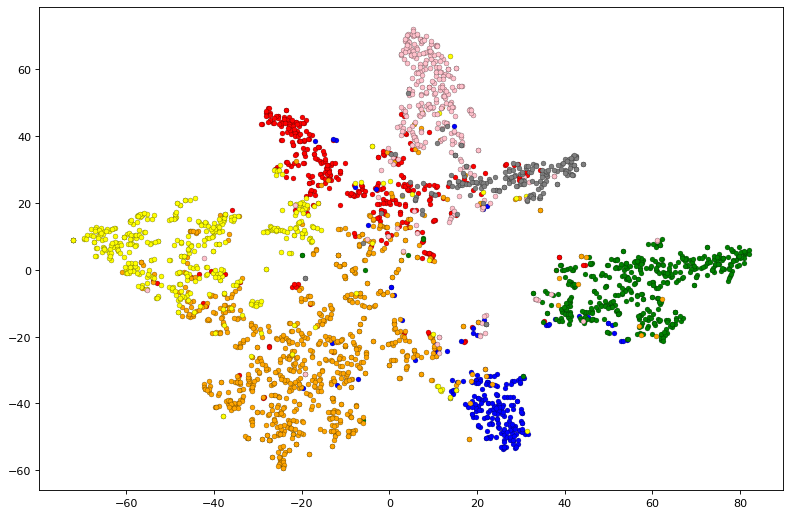

In [23]:
class VisualizationType(enum.Enum):
    ATTENTION = 0,
    EMBEDDINGS = 1,
    ENTROPY = 2,
    
model_name=r'gat_000000.pth'
dataset_name=DatasetType.CORA.name

visualize_gat_properties(
        model_name,
        dataset_name,
        visualization_type=VisualizationType.EMBEDDINGS  # pick between attention, t-SNE embeddings and entropy
)

# Visualize Entropy histograms

They light blue histograms should be skewed compared to the orange one in case when GAT learns something other than a const attention. Unfortunately, Cora is very easy for GAT, so const attention does the job.


***** Model training metadata: *****
commit_hash: 91fb864b8f9ddefd401bf5399cea779bd3c0a63b
dataset_name: CORA
num_of_epochs: 10000
test_acc: 0.822
num_of_layers: 2
num_heads_per_layer: [8, 1]
num_features_per_layer: [1433, 8, 7]
add_skip_connection: False
bias: True
dropout: 0.6
layer_type: IMP3
*************************************



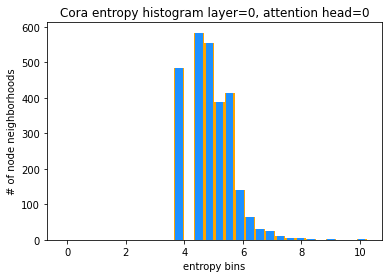

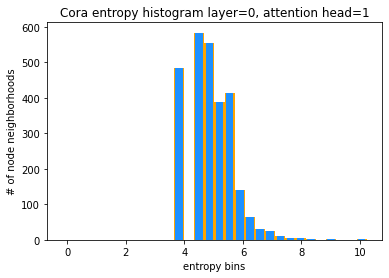

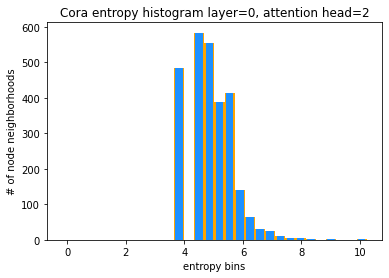

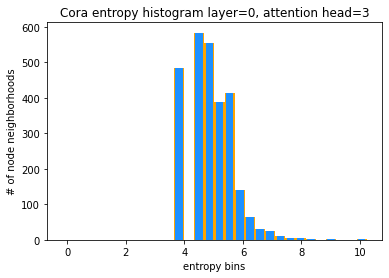

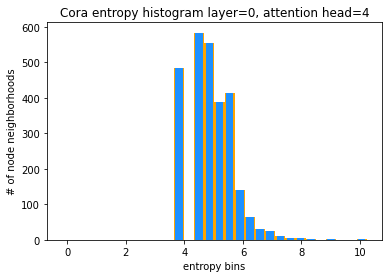

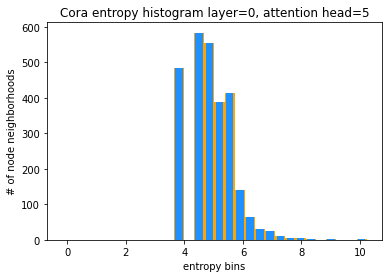

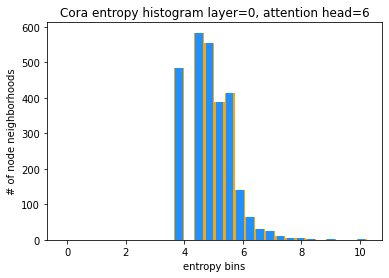

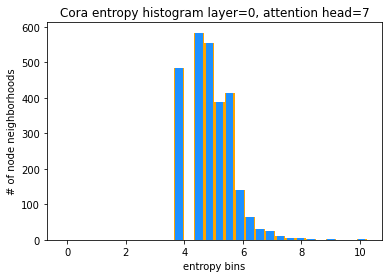

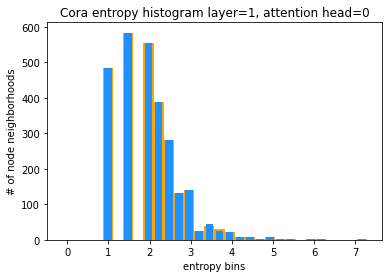

In [26]:
visualize_gat_properties(
        model_name,
        dataset_name,
        visualization_type=VisualizationType.ENTROPY  # pick between attention, t-SNE embeddings and entropy
)

# Visualizing neighborhood attention

Again, unfortunately, igraph is having some problems running in Jupyter so I have to flatten out the content here:


***** Model training metadata: *****
commit_hash: 91fb864b8f9ddefd401bf5399cea779bd3c0a63b
dataset_name: CORA
num_of_epochs: 10000
test_acc: 0.822
num_of_layers: 2
num_heads_per_layer: [8, 1]
num_features_per_layer: [1433, 8, 7]
add_skip_connection: False
bias: True
dropout: 0.6
layer_type: IMP3
*************************************

Highest degree nodes = [1986 1701  306 1358]
Max attention weight = 0.01291587296873331 and min = 0.012394175864756107


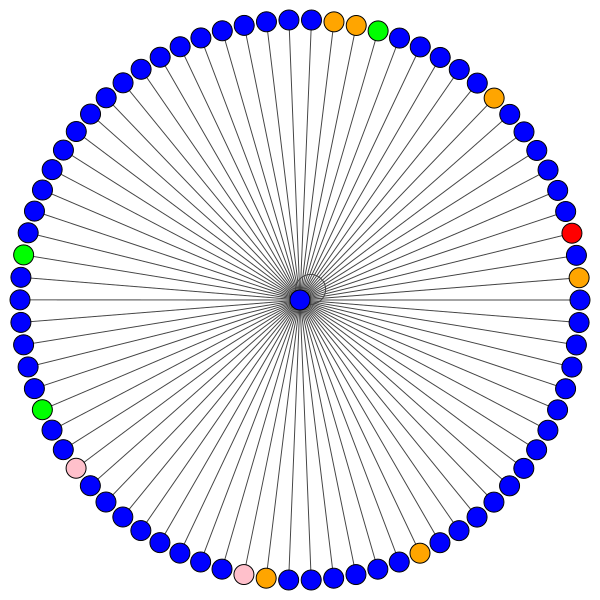

In [27]:
all_nodes_unnormalized_scores, edge_index, node_labels, gat = prepare_vars(model_name, dataset_name, VisualizationType.ATTENTION)

# The number of nodes for which we want to visualize their attention over neighboring nodes
# (2x this actually as we add nodes with highest degree + random nodes)
num_nodes_of_interest = 4  # 4 is an arbitrary number you can play with these numbers
head_to_visualize = 0  # plot attention from this multi-head attention's head
gat_layer_id = 1  # plot attention from this GAT layer

# Build up the complete graph
# node_features shape = (N, FIN), where N is the number of nodes and FIN number of input features
total_num_of_nodes = len(node_features)
complete_graph = ig.Graph()
complete_graph.add_vertices(total_num_of_nodes)  # igraph creates nodes with ids [0, total_num_of_nodes - 1]
edge_index_tuples = list(zip(edge_index[0, :], edge_index[1, :]))  # igraph requires this format
complete_graph.add_edges(edge_index_tuples)

# Pick the target nodes to plot (nodes with highest degree + random nodes)
# Note: there could be an overlap between random nodes and nodes with highest degree - but highly unlikely
highest_degree_node_ids = np.argpartition(complete_graph.degree(), -num_nodes_of_interest)[-num_nodes_of_interest:]
random_node_ids = np.random.randint(low=0, high=total_num_of_nodes, size=num_nodes_of_interest)
print(f'Highest degree nodes = {highest_degree_node_ids}')
      
target_node_ids = edge_index[1]
source_nodes = edge_index[0]

#
# Pick the node id you want to visualize the attention for! (igraph bug)
#

target_node_id = 306  # currently set 2nd highest degree node

# Step 1: Find the neighboring nodes to the target node
# Note: self edge for CORA is included so the target node is it's own neighbor (Alexandro yo soy tu madre)
src_nodes_indices = torch.eq(target_node_ids, target_node_id)
source_node_ids = source_nodes[src_nodes_indices].cpu().numpy()
size_of_neighborhood = len(source_node_ids)

# Step 2: Fetch their labels
labels = node_labels[source_node_ids].cpu().numpy()

# Step 3: Fetch the attention weights for edges (attention is logged during GAT's forward pass above)
# attention shape = (N, NH, 1) -> (N, NH) - we just squeeze the last dim it's superfluous
all_attention_weights = gat.gat_net[gat_layer_id].attention_weights.squeeze(dim=-1)
attention_weights = all_attention_weights[src_nodes_indices, head_to_visualize].cpu().numpy()
# This part shows that for CORA what GAT learns is pretty much constant attention weights! Like in GCN!
print(f'Max attention weight = {np.max(attention_weights)} and min = {np.min(attention_weights)}')
attention_weights /= np.max(attention_weights)  # rescale the biggest weight to 1 for nicer plotting

# Build up the neighborhood graph whose attention we want to visualize
# igraph constraint - it works with contiguous range of ids so we map e.g. node 497 to 0, 12 to 1, etc.
id_to_igraph_id = dict(zip(source_node_ids, range(len(source_node_ids))))
ig_graph = ig.Graph()
ig_graph.add_vertices(size_of_neighborhood)
ig_graph.add_edges([(id_to_igraph_id[neighbor], id_to_igraph_id[target_node_id]) for neighbor in source_node_ids])

# Prepare the visualization settings dictionary and plot
visual_style = {
    "edge_width": attention_weights,  # make edges as thick as the corresponding attention weight
    "layout": ig_graph.layout_reingold_tilford_circular()  # layout for tree-like graphs
}
# This is the only part that's Cora specific as Cora has 7 labels
if dataset_name.lower() == DatasetType.CORA.name.lower():
    visual_style["vertex_color"] = [cora_label_to_color_map[label] for label in labels]
else:
    print('Add custom color scheme for your specific dataset. Using igraph default coloring.')

ig.plot(ig_graph, **visual_style)

Phew!!! That was a mouthful! If you stayed with me until here, **congrats!** (achievement unlocked - GAT master 😍)

Take your time to analyze this notebook. This is not a toy project, it took me ~3 weeks to finish it <br/> 
so don't expect to understand everything in 30 minutes unless you're really familiar with most of the concepts mentioned here.

And last but not least!

# Connect with me

I share lots of useful (I hope so at least!) content on LinkedIn, Twitter, YouTube and Medium. <br/>
So feel free to connect with me there:
1. My [LinkedIn](https://www.linkedin.com/in/aleksagordic) and [Twitter](https://twitter.com/gordic_aleksa) profiles
2. My YouTube channel - [The AI Epiphany](https://www.youtube.com/c/TheAiEpiphany)
3. My [Medium](https://gordicaleksa.medium.com/) profile

Also do drop me a message if you found this useful or if you think I could've done something better! <br/>
I always like getting some feedback on the work I do.

If you notice some bugs/errors feel free to **open up an issue** or even **submit a pull request**.

# Additional resources

Do check out my YouTube videos on GCN, GraphSAGE, PinSage, Temporal Graph Networks, etc.